<a href="https://colab.research.google.com/github/wesleybeckner/general_applications_of_neural_networks/blob/main/notebooks/S4_Computer_Vision_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Applications of Neural Networks <br> Session 4: Computer Vision Part 2 (Defect Detection Case Study)

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

In this session we will continue with our exploration of CNNs. In the previous session we discussed three flagship layers for the CNN: convolution ReLU and maximum pooling. Here we'll discuss the sliding window, how to build your custom CNN, and data augmentation for images.


_images in this notebook borrowed from [Ryan Holbrook](https://mathformachines.com/)_

For more information on the dataset we are using today watch this [video](https://www.youtube.com/watch?v=4sDfwS48p0A)

<br>

---

<br>

<a name='top'></a>

<a name='x.0'></a>

## 4.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 4.0.1 Enabling and testing the GPU

[back to top](#top)

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [155]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


<a name='x.0.2'></a>

### 4.0.2 Observe TensorFlow speedup on GPU relative to CPU

[back to top](#top)

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [156]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.005574539999543
GPU (s):
0.03898585099977936
GPU speedup over CPU: 77x


<a name='x.0.3'></a>

### 4.0.3 Import Packages

[back to top](#top)

In [157]:
# clear memory from cpu/gpu task (skimage load method is ram intensive)
import gc
gc.collect()

1984

In [158]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, feature, filters, exposure, color
from skimage.transform import rescale, resize
from sklearn.metrics import classification_report,confusion_matrix

#importing required tf libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name='x.0.4'></a>

### 4.0.4 Load Dataset

[back to top](#top)

We will actually take a beat here today. When we started building our ML frameworks, we simply wanted our data in a numpy array to feed it into our pipeline. At some point, especially when working with images, the data becomes too large to fit into memory. For this reason we need an alternative way to import our data. With the merger of keras/tf two popular frameworks became available, `ImageDataGenerator` and `image_dataset_from_directory` both under `tf.keras.preprocessing.image`. `image_dataset_from_directory` can sometimes be faster (tf origin) but `ImageDataGenerator` is a lot simpler to use and has on-the-fly data augmentation capability (keras).

For a full comparison of methods visit [this link](https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5)

#### 4.0.4.0 Define Global Parameters

[back to top](#top)

In [159]:
# full dataset can be attained from kaggle if you are interested
# https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product?select=casting_data

# set global parameters for all import dataset methods
image_shape = (300,300,3) # the images actually are 300,300,3
batch_size = 32
validation_split = 0.1
seed_value = 42

folder = '/content/drive/MyDrive/courses/tech_fundamentals/TECH_FUNDAMENTALS/data/casting_data_class_practice'
train_path = folder + '/train/'
test_path = folder + '/test/'

from numpy.random import seed
seed(seed_value)
tf.random.set_seed(seed_value)

#### 4.0.4.1 Loading data with from_tensor_slices

[back to top](#top)

In [160]:
class MyImageLoader: 
    def __init__(self):
        self.classifer = None
        self.folder = folder

    def imread_convert(self, f):
        return io.imread(f).astype(np.uint8)

    def load_data_from_folder(self, dir):
        # type(dir) for plane/ticket/truck/etc dataset
        # else for impellar dataset
        filetype = set([i.split('.')[-1] for i in [x[2] for x in os.walk(folder + dir)][1:][0]])
        if len(filetype) != 1:
          raise Exception('Multiple filetypes in directory, will cause error')
        suffix = filetype.pop()

        dirs = [x[0] + f'/*.{suffix}' for x in os.walk(self.folder + dir) if x[0].split('/')[-1] != '']
        dirs = ':'.join(dirs)
        ic = io.ImageCollection(dirs, load_func=self.imread_convert)

        # infer labels from directory structure
        label_names = [x[1] for x in os.walk(folder + dir)][0]
        img_amounts = [len(y) for y in [x[2] for x in os.walk(folder + dir)][1:]]
        labels = [item for sublist in [[i]*j for i,j in zip(label_names, img_amounts)] for item in sublist]
        labels = np.array(labels)

        #create one large array of image data
        data = io.concatenate_images(ic)

        #resize to target shape (memory intensive)
        # data = resize(data, (data.shape[0], *image_shape[:2])) #uncomment if you need to resize images
        return(data,labels)

# Create an object of the class `MyImageLoader`
img_clf = MyImageLoader()

# load images
(train_val_raw, train_val_labels) = img_clf.load_data_from_folder('/train/')
(test_raw, test_labels) = img_clf.load_data_from_folder('/test/')
train_val_raw = train_val_raw.astype(np.float32)
test_raw = test_raw.astype(np.float32)
classes = list(np.unique(train_val_labels))
print(f"Classes: {classes}")
print("train and validation labels: {}".format(len(train_val_labels)))
print("test labels: {}".format(len(test_labels)))

# convert labels to numeric
for i in range(len(classes)):
    train_val_labels[train_val_labels == classes[i]] = i
    test_labels[test_labels == classes[i]] = i

train_val_labels = train_val_labels.astype(float)
test_labels = test_labels.astype(float)

# create train/val/test and shuffle
train_val_dataset = tf.data.Dataset.from_tensor_slices((train_val_raw, train_val_labels)) 
test_dataset = tf.data.Dataset.from_tensor_slices((test_raw, test_labels)) 

train_val_dataset = train_val_dataset.shuffle(buffer_size=len(train_val_dataset), seed=seed_value)
test_dataset = test_dataset.shuffle(buffer_size=len(test_dataset), seed=seed_value)     


# use validation_split
val_len = int(validation_split * len(train_val_raw))
val_dataset = train_val_dataset.take(val_len)
train_dataset = train_val_dataset.skip(val_len)
print(f"Train size: {len(train_dataset)}\nVal size: {len(val_dataset)}\nTest size: {len(test_dataset)}")

# batch the data
train_dataset_batched = train_dataset.batch(batch_size)
val_dataset_batched = val_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

print(f"Train batches: {len(train_dataset_batched)}\nVal batches: {len(val_dataset_batched)}\nTest batches: {len(test_dataset_batched)}")

Classes: ['def_front', 'ok_front']
train and validation labels: 840
test labels: 678
Train size: 756
Val size: 84
Test size: 678
Train batches: 24
Val batches: 3
Test batches: 22


<a name='x.0.4.1'></a>

#### 4.0.4.2 Loading Data with `ImageDataGenerator`

[back to top](#top)

In [161]:
image_gen = ImageDataGenerator(rescale=1/255,
                               validation_split=validation_split) # normalize pixels to 0-1

#we're using keras inbuilt function to ImageDataGenerator so we 
# dont need to label all images into 0 and 1 
print("loading training set...")
train_set_keras = image_gen.flow_from_directory(train_path,
                                          target_size=image_shape[:2],
                                          color_mode="rgb",
                                          batch_size=batch_size,
                                          class_mode="sparse",
                                          subset="training",
                                          shuffle=True,
                                          seed=seed_value)
print("loading validation set...")
val_set_keras = image_gen.flow_from_directory(train_path,
                                          target_size=image_shape[:2],
                                          color_mode="rgb",
                                          batch_size=batch_size,
                                          class_mode="sparse",
                                          subset="validation",
                                          shuffle=True,
                                          seed=seed_value)
print("loading testing set...")
test_set_keras = image_gen.flow_from_directory(test_path,
                                          target_size=image_shape[:2],
                                          color_mode="rgb",
                                          batch_size=batch_size,
                                          class_mode="sparse",
                                          shuffle=False)

loading training set...
Found 757 images belonging to 2 classes.
loading validation set...
Found 83 images belonging to 2 classes.
loading testing set...
Found 678 images belonging to 2 classes.


<a name='x.0.4.2'></a>

#### 4.0.4.3 loading data with `image_dataset_from_directory`

[back to top](#top)

This method should be approx 2x faster than `ImageDataGenerator`

In [162]:
# Load training and validation sets
print("loading training set...")
ds_train_ = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=image_shape[:2],
    batch_size=batch_size,
    validation_split=validation_split,
    subset="training",
    shuffle=True,
    seed=seed_value,
)
print("loading validation set...")
ds_val_ = image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=image_shape[:2],
    batch_size=batch_size,
    validation_split=validation_split,
    subset="validation",
    shuffle=True,
    seed=seed_value,
)
print("loading testing set...")
ds_test_ = image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=image_shape[:2],
    batch_size=batch_size,
    shuffle=False,
)

train_set_tf = ds_train_.prefetch(buffer_size=AUTOTUNE)
val_set_tf = ds_val_.prefetch(buffer_size=AUTOTUNE)
test_set_tf = ds_test_.prefetch(buffer_size=AUTOTUNE)

loading training set...
Found 840 files belonging to 2 classes.
Using 756 files for training.
loading validation set...
Found 840 files belonging to 2 classes.
Using 84 files for validation.
loading testing set...
Found 678 files belonging to 2 classes.


#### 4.0.4.4 View Images

[back to top](#top)

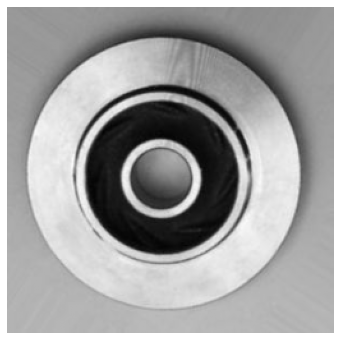

In [163]:
# view some images
def_path = '/def_front/cast_def_0_1001.jpeg'
ok_path = '/ok_front/cast_ok_0_1.jpeg'
image_path = train_path + ok_path
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)
image = resize(image, (256, 256),
                anti_aliasing=True)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

<a name='x.1'></a>

## 4.1 Understanding the Sliding Window

[back to top](#top)

The kernels we just reviewed, need to be swept or _slid_ along the preceding layer. We call this a **_sliding window_**, the window being the kernel. 

<p align=center>
<img src="https://raw.githubusercontent.com/wesleybeckner/general_applications_of_neural_networks/main/assets/LueNK6b.gif" width=400></img>
</p>

What do you notice about the gif? One perhaps obvious observation is that you can't scoot all the way up to the border of the input layer, this is because the kernel defines operations _around_ the centered pixel and so you bang up against the margin of the input array. We can change the behavior at the boundary with a **_padding_** hyperparameter. A second observation, is that the distance we move the kernel along in each step could be variable, we call this the **_stride_**. We will explore the affects of each of these.



In [164]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

<a name='x.1.1'></a>

### 4.1.1 Stride

[back to top](#top)

Stride defines the the step size we take with each kernel as it passes along the input array. The stride needs to be defined in both the horizontal and vertical dimensions. This animation shows a 2x2 stride


<p align=center>
<img src="https://raw.githubusercontent.com/wesleybeckner/general_applications_of_neural_networks/main/assets/Tlptsvt.gif" width=400></img>
</p>

The stride will often be 1 for CNNs, where we don't want to lose any important information. Maximum pooling layers will often have strides greater than 1, to better summarize/accentuate the relevant features/activations.

If the stride is the same in both the horizontal and vertical directions, it can be set with a single number like `strides=2` within keras.



### 4.1.2 Padding

[back to top](#top)

Padding attempts to resolve our issue at the border: our kernel requires information surrounding the centered pixel, and at the border of the input array we don't have that information. What to do?

We have a couple popular options within the keras framework. We can set `padding='valid'` and only slide the kernel to the edge of the input array. This has the drawback of feature maps shrinking in size as we pass through the NN. Another option is to set `padding='same'` what this will do is pad the input array with 0's, just enough of them to allow the feature map to be the same size as the input array. This is shown in the gif below:


<p align=center>
<img src="https://raw.githubusercontent.com/wesleybeckner/general_applications_of_neural_networks/main/assets/RvGM2xb.gif" width=400></img>
</p>

The downside of setting the padding to same will be that features at the edges of the image will be diluted. 

<a name='x.1.3'></a>

### 🏋️ Exercise 1: Exploring Sliding Windows

[back to top](#top)

In [165]:
from skimage import draw, transform
from itertools import product
# helper functions borrowed from Ryan Holbrook
# https://mathformachines.com/

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

Create an image and kernel:

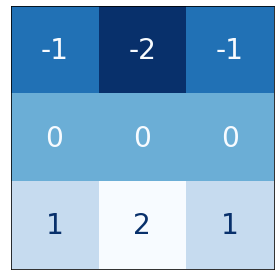

In [166]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

What do we think this kernel is meant to detect for?

We will apply our kernel with a 1x1 stride and our max pooling with a 2x2 stride and pool size of 2.

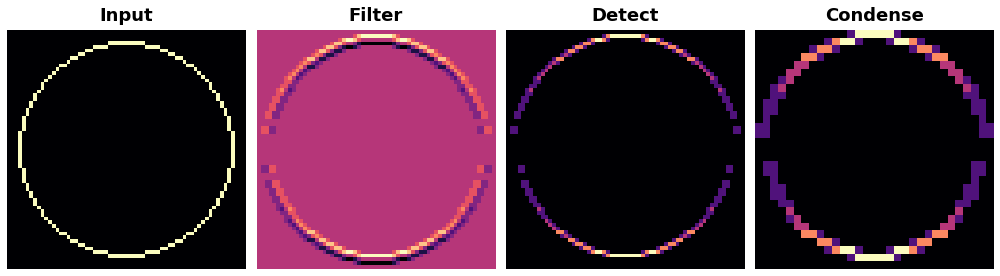

In [167]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

Works ok! what about a higher conv stride?

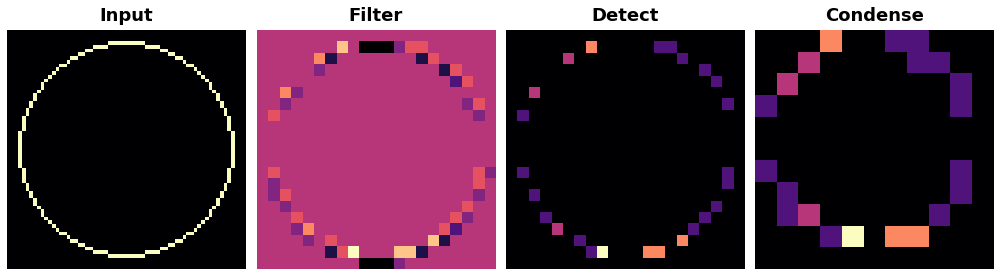

In [168]:
show_extraction(
    image, kernel,

    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,

    subplot_shape=(1, 4),
    figsize=(14, 6),
)

Looks like we lost a bit of information!

Sometimes published models will use a larger kernel and stride in the initial layer to produce large-scale features early on in the network without losing too much information (ResNet50 uses 7x7 kernels with a stride of 2). For now, without having much experience it's safe to set conv strides to 1.

Take a moment here with the given kernel and explore different settings for applying both the kernel and the max_pool

```
conv_stride=YOUR_VALUE, # condenses pixels
pool_size=YOUR_VALUE,
pool_stride=YOUR_VALUE, # condenses pixels
```

Given a total condensation of 8 (I'm taking condensation to mean `conv_stride` x `pool_stride`). what do you think is the best combination of values for `conv_stride, pool_size, and pool_stride`?

<a name='x.2'></a>

## 4.2 Building a Custom CNN

[back to top](#top)

As we move through the network, small-scale features (lines, edges, etc.) turn to large-scale features (shapes, eyes, ears, etc). We call these blocks of convolution, ReLU, and max pool **_convolutional blocks_** and they are the low level modular framework we work with. By this means, the CNN is able to design it's own features, ones suited for the classification or regression task at hand. 

We will design a custom CNN for the Casting Defect Detection Dataset.

### 4.2.1 Define Architecture

[back to top](#top)

In the following I'm going to double the filter size after the first block. This is a common pattern as the max pooling layers forces us in the opposite direction.

In [169]:
def build_model():
  # Creating model
  model = Sequential()

  model.add(InputLayer(input_shape=(image_shape)))

  model.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu',))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(224))
  model.add(Activation('relu'))

  # Last layer
  model.add(Dense(2))

  base_learning_rate = 0.001
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                metrics=['accuracy'])

  print(model.summary())
  return model

early_stop = EarlyStopping(monitor='val_loss',
                            patience=5,
                            restore_best_weights=True,)

<a name='x.2.1'></a>

### 4.2.1 Train and Evaluate Model

[back to top](#top)

To save/load weights and training history:
```
# model.save('inspection_of_casting_products.h5')
# model.load_weights('inspection_of_casting_products.h5')
# losses.to_csv('history_simple_model.csv', index=False)
```

#### 4.2.1.1 from_tensor_slices

[back to top](#top)

In [170]:
%%time
model = build_model()
with tf.device('/device:GPU:0'):
  results = model.fit(train_dataset_batched,
                      epochs=30,
                      validation_data=val_dataset_batched,
                      callbacks=[early_stop]
                      )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 149, 149, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 71, 71, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 16)      

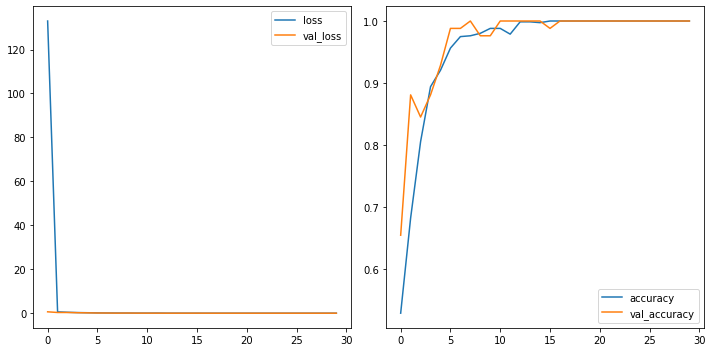

In [171]:
losses = pd.DataFrame(results.history)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
losses[['loss','val_loss']].plot(ax=ax[0])
losses[['accuracy','val_accuracy']].plot(ax=ax[1])

##### 4.2.1.1.1 Evaluate

[back to top](#top)

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.79       439
         1.0       0.65      0.83      0.73       265

    accuracy                           0.76       704
   macro avg       0.76      0.78      0.76       704
weighted avg       0.79      0.76      0.77       704



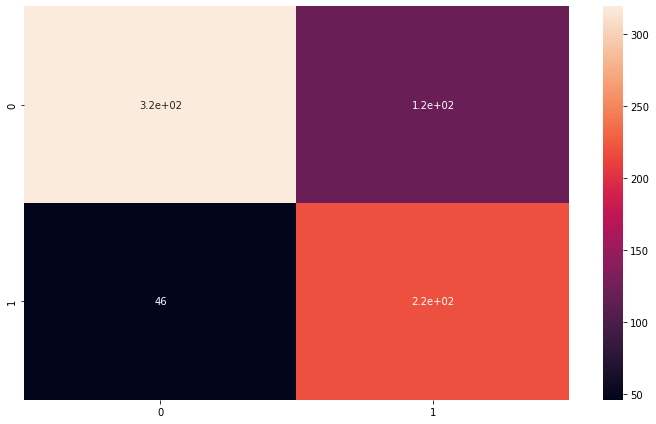

In [172]:
pred = []
label = []
for batch in range(len(test_dataset_batched)):
  image_batch, label_batch = test_dataset_batched.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).argmax(axis=1)
  # print(f"Labels     : {label_batch}\nPredictions: {predictions.astype(float)}")
  pred.append(predictions)
  label.append(label_batch)
predictions = np.array(pred).flatten()
labels = np.array(label).flatten()
print(classification_report(labels,predictions))

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

#### 4.2.1.2 TF - image_dataset_from_directory

[back to top](#top)

In [173]:
%%time
model = build_model()
with tf.device('/device:GPU:0'):
  results = model.fit(train_set_tf,
                      epochs=30,
                      validation_data=val_set_tf,
                      callbacks=[early_stop]
                      )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 149, 149, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 71, 71, 16)        2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 35, 35, 16)      

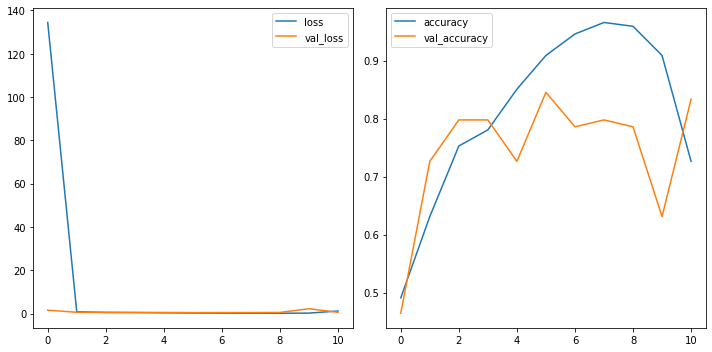

In [174]:
losses = pd.DataFrame(results.history)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
losses[['loss','val_loss']].plot(ax=ax[0])
losses[['accuracy','val_accuracy']].plot(ax=ax[1])

##### 4.2.1.2.1 Evaluate

[back to top](#top)

              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87       416
         1.0       0.75      0.94      0.83       262

    accuracy                           0.85       678
   macro avg       0.85      0.87      0.85       678
weighted avg       0.88      0.85      0.86       678



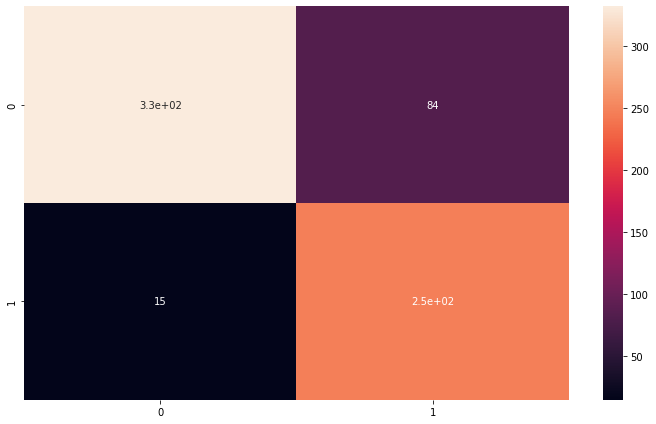

In [175]:
predictions = model.predict(test_set_tf).argmax(axis=1)
labels = np.array([])
for x, y in ds_test_:
  labels = np.concatenate([labels, tf.squeeze(y.numpy()).numpy()])
print(classification_report(labels,predictions))
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

#### 4.2.1.3 Keras - ImageDataGenerator

[back to top](#top)

In [176]:
%%time
model = build_model()
with tf.device('/device:GPU:0'):
  results = model.fit(train_set_keras,
                      epochs=30,
                      validation_data=val_set_keras,
                      callbacks=[early_stop]
                      )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 149, 149, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 147, 147, 16)      1168      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_84 (Conv2D)          (None, 71, 71, 16)        2320      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 35, 35, 16)      

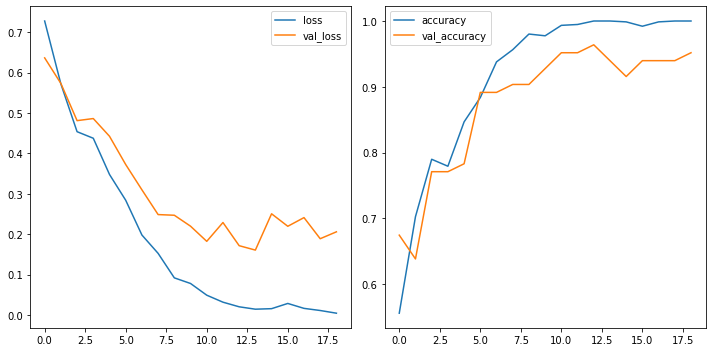

In [177]:
losses = pd.DataFrame(results.history)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
losses[['loss','val_loss']].plot(ax=ax[0])
losses[['accuracy','val_accuracy']].plot(ax=ax[1])

##### 4.2.1.3.1 Evaluate

[back to top](#top)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       416
           1       0.92      0.97      0.95       262

    accuracy                           0.96       678
   macro avg       0.95      0.96      0.96       678
weighted avg       0.96      0.96      0.96       678



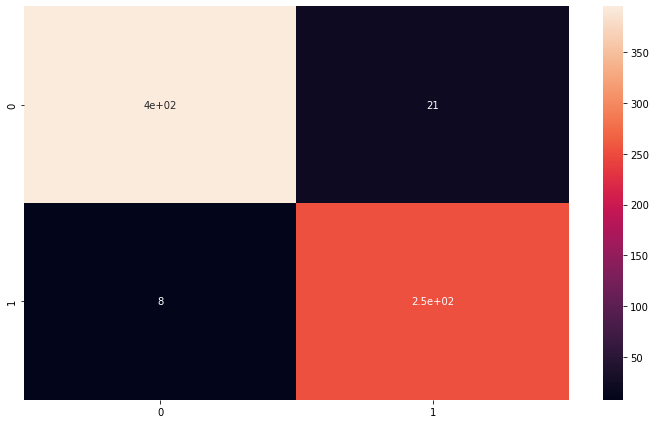

In [178]:
predictions = model.predict(test_set_keras).argmax(axis=1)
labels = test_set_keras.classes
print(classification_report(labels,predictions))
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

### 🏋️ Exercise 2: Binary Output

In the above, we used a type of loss function called *sparse categorical crossentropy*

This loss is useful when we have many target classes set as different integers, i.e.

```
good = 1
bad = 2
ugly = 3
```

another type of loss function is *categorical crossentropy* this is for when the target classes are one-hot encoded, i.e.

```
good = [1,0,0]
bad = [0,1,0]
ugly = [0,0,1]
```

1. Choose one of the datatset import methods from above
2. Specify the labels as binary during the loading process
3. Redefine the model using 
  * a single dense node as the final layer with
  * a sigmoidal activation function
4. Compile with the new loss set to 'binary_crossentropy',
5. Train the model
6. Evaluate the F1/Precision/Recall metrics and display the confusion matrix. 
  * *note: our prior method of obtaining the classification using `argmax` will not work, as the output is now a probability score ranging 0-1*

In [179]:
# Code cell for exercise 2

<a name='x.3'></a>

## 4.3 Data Augmentation

[back to top](#top)

Alright, alright, alright. We've done pretty good making our CNN model. But let's see if we can make it even better. There's a last trick we'll cover here in regard to image classifiers. We're going to perturb the input images in such a way as to create a pseudo-larger dataset.

With any machine learning model, the more relevant training data we give the model, the better. The key here is _relevant_ training data. We can easily do this with images so long as we do not change the class of the image. For example, in the small plot below, we are changing contrast, hue, rotation, and doing other things to the image of a car; and this is okay because it does not change the classification from a car to, say, a truck.

<p align=center>
<img src="https://raw.githubusercontent.com/wesleybeckner/general_applications_of_neural_networks/main/assets/UaOm0ms.png" width=400></img>
</p>

Typically when we do data augmentation for images, we do them _online_, i.e. during training. Recall that we train in batches (or minibatches) with CNNs. An example of a minibatch then, might be the small multiples plot below.

<p align=center>
<img src="https://raw.githubusercontent.com/wesleybeckner/general_applications_of_neural_networks/main/assets/MFviYoE.png" width=400></img>
</p>

by varying the images in this way, the model always sees slightly new data, and becomes a more robust model. Remember that the caveat is that we can't muddle the relevant classification of the image. Sometimes the best way to see if data augmentation will be helpful is to just try it and see!

### 4.3.1 Define Architecture

[back to top](#top)

In [180]:
#Creating model
model = Sequential()

model.add(InputLayer(input_shape=(image_shape)))

model.add(preprocessing.RandomFlip('horizontal', seed=seed_value)), # flip left-to-right
model.add(preprocessing.RandomFlip('vertical', seed=seed_value)), # flip upside-down
model.add(preprocessing.RandomContrast(0.1, seed=seed_value)), # contrast change by up to 50%
model.add(preprocessing.RandomRotation(factor=1, fill_mode='constant', seed=seed_value))

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(2))

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,)

base_learning_rate = 0.001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 300, 300, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 300, 300, 3)      0         
 rast)                                                           
                                                                 
 random_rotation (RandomRota  (None, 300, 300, 3)      0         
 tion)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 149, 149, 8)     

In [181]:
%%time
results = model.fit(train_set_tf,
                    epochs=30,
                    validation_data=val_set_tf,
                    callbacks=[early_stop])

Epoch 1/30
24/24 [==============================] - 4s 91ms/step - loss: 93.7654 - accuracy: 0.5503 - val_loss: 1.5286 - val_accuracy: 0.6190
Epoch 2/30
24/24 [==============================] - 2s 83ms/step - loss: 1.0640 - accuracy: 0.6508 - val_loss: 0.6292 - val_accuracy: 0.7024
Epoch 3/30
24/24 [==============================] - 2s 84ms/step - loss: 0.6656 - accuracy: 0.6944 - val_loss: 0.5734 - val_accuracy: 0.7143
Epoch 4/30
24/24 [==============================] - 2s 83ms/step - loss: 0.5832 - accuracy: 0.7037 - val_loss: 0.5793 - val_accuracy: 0.7143
Epoch 5/30
24/24 [==============================] - 3s 86ms/step - loss: 0.5902 - accuracy: 0.7235 - val_loss: 0.5230 - val_accuracy: 0.7500
Epoch 6/30
24/24 [==============================] - 2s 83ms/step - loss: 0.5396 - accuracy: 0.7447 - val_loss: 0.5276 - val_accuracy: 0.7738
Epoch 7/30
24/24 [==============================] - 2s 84ms/step - loss: 0.4809 - accuracy: 0.7672 - val_loss: 0.4934 - val_accuracy: 0.8095
Epoch 8/30
2

<a name='x.3.1'></a>

### 4.3.2 Evaluate Model

[back to top](#top)

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       416
         1.0       0.86      0.98      0.91       262

    accuracy                           0.93       678
   macro avg       0.92      0.94      0.93       678
weighted avg       0.94      0.93      0.93       678



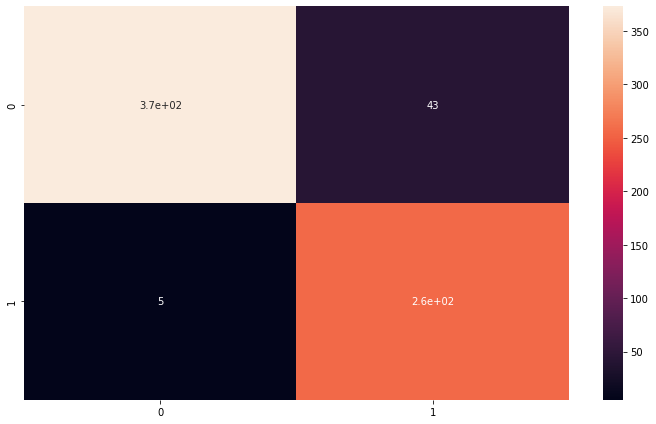

In [182]:
predictions = model.predict(test_set_tf).argmax(axis=1)
labels = np.array([])
for x, y in ds_test_:
  labels = np.concatenate([labels, tf.squeeze(y.numpy()).numpy()])
print(classification_report(labels,predictions))
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

<a name='x.3.2'></a>

### 🏋️ Exercise 3: Image Preprocessing Layers

[back to top](#top)

These layers apply random augmentation transforms to a batch of images. They are only active during training. You can visit the documentation [here](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/)

* `RandomCrop` layer
* `RandomFlip` layer
* `RandomTranslation` layer
* `RandomRotation` layer
* `RandomZoom` layer
* `RandomHeight` layer
* `RandomWidth` layer

Use any combination of random augmentation transforms and retrain your model. Can you get a higher val performance? you may need to increase your epochs.

In [183]:
# Code cell for exercise 3

<a name='x.4'></a>

## 4.4 Transfer Learning

[back to top](#top)

MobileNetV2 - A general purpose, deployable computer vision neural network designed by Google that works efficiently for classification, detection and segmentation.  

![](https://miro.medium.com/max/1016/1*5iA55983nBMlQn9f6ICxKg.png)

### 4.4.1 Define Architecture

[back to top](#top)

In [184]:
### COMPONENTS (IN ORDER)
resize = layers.experimental.preprocessing.Resizing(224,224)
preprocess_input_fn = tf.keras.applications.mobilenet_v2.preprocess_input 
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(classes))

9420800/9406464 [==============================] - 0s 0us/step


In [185]:
### MODEL
inputs = tf.keras.Input(shape=image_shape)
x = resize(inputs)
x = preprocess_input_fn(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [186]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 4.4.2 Train Head

[back to top](#top)

In [187]:
%%time
with tf.device('/device:GPU:0'):
  results = model.fit(train_set_tf,
                      epochs=60,
                      validation_data=val_set_tf,
                      callbacks=[early_stop]
                      )

Epoch 1/50
24/24 [==============================] - 6s 130ms/step - loss: 0.8879 - accuracy: 0.4431 - val_loss: 0.7634 - val_accuracy: 0.4643
Epoch 2/50
24/24 [==============================] - 3s 86ms/step - loss: 0.8257 - accuracy: 0.4815 - val_loss: 0.6939 - val_accuracy: 0.5238
Epoch 3/50
24/24 [==============================] - 2s 85ms/step - loss: 0.7602 - accuracy: 0.5278 - val_loss: 0.6392 - val_accuracy: 0.6071
Epoch 4/50
24/24 [==============================] - 3s 87ms/step - loss: 0.6970 - accuracy: 0.5847 - val_loss: 0.5912 - val_accuracy: 0.6905
Epoch 5/50
24/24 [==============================] - 3s 86ms/step - loss: 0.6381 - accuracy: 0.6336 - val_loss: 0.5536 - val_accuracy: 0.7857
Epoch 6/50
24/24 [==============================] - 3s 88ms/step - loss: 0.6212 - accuracy: 0.6521 - val_loss: 0.5171 - val_accuracy: 0.8571
Epoch 7/50
24/24 [==============================] - 3s 87ms/step - loss: 0.5816 - accuracy: 0.6905 - val_loss: 0.4897 - val_accuracy: 0.8929
Epoch 8/50
2

### 4.4.3 Evaluate Model

[back to top](#top)

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       416
         1.0       0.89      0.95      0.92       262

    accuracy                           0.94       678
   macro avg       0.93      0.94      0.93       678
weighted avg       0.94      0.94      0.94       678



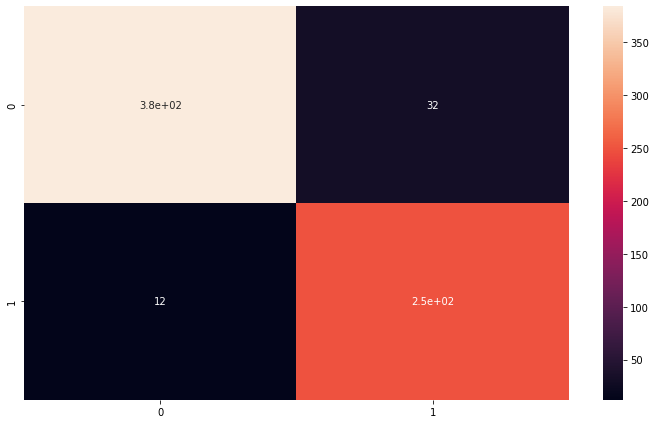

In [188]:
predictions = model.predict(test_set_tf).argmax(axis=1)
labels = np.array([])
for x, y in ds_test_:
  labels = np.concatenate([labels, tf.squeeze(y.numpy()).numpy()])
print(classification_report(labels,predictions))
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

### 🏋️ Exercise 4: Transfer Learn with other Base Models

visit [keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and read about 2-3 of the available models. Choose one and reimplement our transfer learning procedure from above!

In [189]:
# Code cell for exercise 4

## 4.5 Augmentation + Transfer Learning

[back to top](#top)

In [194]:
### COMPONENTS (IN ORDER)
resize = layers.experimental.preprocessing.Resizing(224,224)
preprocess_input_fn = tf.keras.applications.mobilenet_v2.preprocess_input 
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(classes))

aug1 = preprocessing.RandomFlip('horizontal', seed=seed_value) # flip left-to-right
aug2 = preprocessing.RandomFlip('vertical', seed=seed_value)
aug3 = preprocessing.RandomContrast(0.2, seed=seed_value)
aug4 = preprocessing.RandomRotation(factor=0.25, fill_mode='constant', seed=seed_value)

### MODEL
inputs = tf.keras.Input(shape=image_shape)
x = aug1(inputs)
x = aug2(x)
x = aug3(x)
x = aug4(x)
x = resize(x)
x = preprocess_input_fn(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [195]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 300, 300, 3)]     0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 300, 300, 3)       0         
                                                                 
 random_contrast_2 (RandomCo  (None, 300, 300, 3)      0         
 ntrast)                                                         
                                                                 
 random_rotation_2 (RandomRo  (None, 300, 300, 3)      0         
 tation)                                                         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [196]:
%%time
with tf.device('/device:GPU:0'):
  results = model.fit(train_set_tf,
                      epochs=60,
                      validation_data=val_set_tf,
                      callbacks=[early_stop]
                      )

Epoch 1/60
24/24 [==============================] - 6s 121ms/step - loss: 1.1031 - accuracy: 0.4749 - val_loss: 0.7784 - val_accuracy: 0.4405
Epoch 2/60
24/24 [==============================] - 3s 91ms/step - loss: 0.9019 - accuracy: 0.4272 - val_loss: 0.7770 - val_accuracy: 0.5000
Epoch 3/60
24/24 [==============================] - 3s 91ms/step - loss: 0.8208 - accuracy: 0.4828 - val_loss: 0.7223 - val_accuracy: 0.5238
Epoch 4/60
24/24 [==============================] - 3s 91ms/step - loss: 0.7530 - accuracy: 0.5397 - val_loss: 0.6936 - val_accuracy: 0.5476
Epoch 5/60
24/24 [==============================] - 3s 92ms/step - loss: 0.7356 - accuracy: 0.5331 - val_loss: 0.6617 - val_accuracy: 0.5595
Epoch 6/60
24/24 [==============================] - 3s 91ms/step - loss: 0.6974 - accuracy: 0.5714 - val_loss: 0.6388 - val_accuracy: 0.5595
Epoch 7/60
24/24 [==============================] - 3s 88ms/step - loss: 0.6557 - accuracy: 0.5992 - val_loss: 0.6129 - val_accuracy: 0.5833
Epoch 8/60
2

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88       416
         1.0       0.99      0.56      0.72       262

    accuracy                           0.83       678
   macro avg       0.88      0.78      0.80       678
weighted avg       0.86      0.83      0.81       678



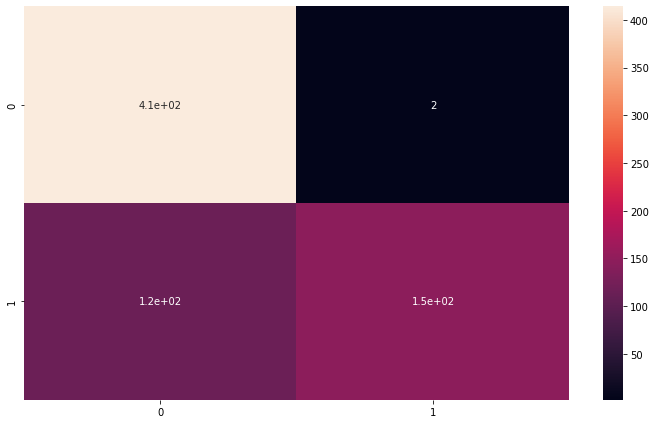

In [197]:
predictions = model.predict(test_set_tf).argmax(axis=1)
labels = np.array([])
for x, y in ds_test_:
  labels = np.concatenate([labels, tf.squeeze(y.numpy()).numpy()])
print(classification_report(labels,predictions))
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(labels,predictions), annot=True)

## 4.6 Summary

[back to top](#top)

If you ran this notebook as-is you should've gotten something similar to the following table

| Data Handling | Model       | Data Augmentation | Weighted F1 | Training Time (min:sec) |
|---------------|-------------|-------------------|-------------|-------------------------|
| ImageDataGenerator         | CNN         | No                | 0.96        | 1:00                    |
| from_directory    | CNN         | No                | 0.86        | 0:39                    |
| from_tensor  | CNN         | No                | 0.77        | 0:47                    |
| from_directory    | CNN         | Yes               | 0.93        | 2:04                    |
| from_directory    | MobileNetV2 | No                | 0.94        | 3:41                    |

In conclusion, we can see an appreciable difference in speed when we decide to transfer learn or augment the original dataset. Curiously, Loading our data with scikit-image gives us the best performance in our custom CNN model.